I have used Google's Colab Notebook to implement this project. The working directory for coloab is the "Content" folder. We can see the available folder structure from clicking on the folder icon on the left.There we can upload files from our local system.

In [2]:
import os
import json
import zipfile
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

print(tf.__version__)
local_zip = 'Reduced_News_Category_Dataset.zip' #Name of the zip file that will be uploaded
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('News_Category') #extracting the zip file and putting it in folder named 'News_Category' 
zip_ref.close()

2.2.0-rc4


<h3>Initializing the Parameters</h3>

It's a good exercise if we initiaize the parameter values in one place that we will be using going forward. So while doing experiments with the training outcome, we will need to change the values in only one place.

In [0]:
vocab_size = 10000     #specifies the the maximum number of words to be tokenized 
                      #and takes the most common n number of words
embedding_dim = 16    #the number of dimensions for the vector representing a word encoding 
max_length = 120      #to initialize the maximum padding length
trunc_type='post'     #to truncate words from the end of the sequence
padding_type='post'   #to add padding at the end of the sequence
oov_tok = "<OOV>"     #Need to specify a token to use for unknown words 
                      #otherwise the word will not be encoded and will be skipped in the sequence
training_size = 40000

<h3>Getting Data</h3>

We will be working only with the 'Headline' and the 'Category' of dataset. So here we will be storing the rescpective data in 'sentences' and 'lables' respectively.

In [5]:
with open("News_Category/News_Category_Dataset_Updated.json", 'r') as f:
  datastore = json.load(f)

sentences = []
labels = []
for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['category'])

print(len(sentences))
print(len(labels))
print(len("We Shall Overcomb!” Say The 100,000 Marching Against Trump In London"))
print(max(sentences))
print((sentences[0:7])) #prints first 7 sentences from the array
print((labels[0:7]))    #prints first 7 labels from the array

49999
49999
68
“We Shall Overcomb!” Say The 100,000 Marching Against Trump In London
['There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV', "Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song", 'Hugh Grant Marries For The First Time At Age 57', "Jim Carrey Blasts 'Castrato' Adam Schiff And Democrats In New Artwork", 'Julianna Margulies Uses Donald Trump Poop Bags To Pick Up After Her Dog', "Morgan Freeman 'Devastated' That Sexual Harassment Claims Could Undermine Legacy", "Donald Trump Is Lovin' New McDonald's Jingle In 'Tonight Show' Bit"]
['CRIME', 'ENTERTAINMENT', 'ENTERTAINMENT', 'ENTERTAINMENT', 'ENTERTAINMENT', 'ENTERTAINMENT', 'ENTERTAINMENT']


<h3>Tokenizing the 'Lables' and 'Sentences'</h3>

1. The first step of "Natural Language Processing" is to encode the sentnce, which is basically assigning unique values to each words.

2. This process of assigning unique value to each word is called Tokenzing. 

3. First each and every words are tokenized and then based on that token the sences are then encoded.   

In [10]:
training_sentences = sentences[0:training_size] 
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

print(len(training_sentences))
print(len(testing_sentences))

#initializing the 'Tokenizer' object
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

#'fit_on_texts' method is used to tokenize a list of sentences
tokenizer.fit_on_texts(training_sentences)

#The tokenizer provides a word index property which returns a dictionary containing key value pairs,
#where the key is the word, and the value is the token for that word.
word_index = tokenizer.word_index
#which you can inspect by simply printing it out
#print(word_index)

#Once the corpus has been tokenized, "texts_to_sequences" is the method 
#used to encode a list of sentences to use those tokens
training_sequences = tokenizer.texts_to_sequences(training_sentences)

#In case of sequences of different lengths, "pad_sequences" method is used
#to padd the sentnces to our desired length according to the 'maxlen', 'padding' and 'truncating' arguments
#so they are understood when fed into a neural network
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

#tokeninzing the labels
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = label_tokenizer.texts_to_sequences(training_labels)
testing_label_seq = label_tokenizer.texts_to_sequences(testing_labels)

40000
9999


<h3>Embedding: Where the Magic Happens</h3>

This is the key to get the text sentiment analysis in TensorFLow. Through embedding we map a word in sentence to a vector in a higher dimension space. So words having similar meaning are mapped to similar vectors and by this the words(having similar meaning) in terms of vector began to cluster together. 

The meaning of the word is taken from label the of the dataset.    

In [11]:
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),

  tf.keras.layers.Conv1D(128, 5, activation='relu'), #]different type of intermediate layers: either this can be used
                                                       #|
  tf.keras.layers.GlobalAveragePooling1D(),          #]

    #LSTM helps to understand the meaning when words aren't necessarily beside each other in a sentence
    # it is done by carrying the value of words to later or prior of those words via cell state
    #'Bidirectional' keras layer helps to carry this in both way

  # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)), #]different type of intermediate layers: or this can be used

  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(31, activation='softmax')
])
#As more than one classes are present here 'sparse_categorical_crossentropy' is used
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
conv1d (Conv1D)              (None, 116, 128)          10368     
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dense_1 (Dense)              (None, 31)                3999      
Total params: 190,879
Trainable params: 190,879
Non-trainable params: 0
_________________________________________________________________


<h3>Trainging the Model</h3>

Now we have developed the model,it's time to train it. 'model.fit()' helps us to do so.

In [12]:
num_epochs = 30

#converting to Numpy Array as the model expects in that data type  
training_padded = np.array(training_padded)
training_labels = np.array(training_label_seq)

testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_label_seq)

history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=1)

Epoch 1/30
1250/1250 [==============================] - 15s 12ms/step - loss: 2.3328 - accuracy: 0.4051 - val_loss: 2.3373 - val_accuracy: 0.4148
Epoch 2/30
1250/1250 [==============================] - 15s 12ms/step - loss: 1.9856 - accuracy: 0.4585 - val_loss: 2.2021 - val_accuracy: 0.4239
Epoch 3/30
1250/1250 [==============================] - 15s 12ms/step - loss: 1.8407 - accuracy: 0.4825 - val_loss: 2.1538 - val_accuracy: 0.4289
Epoch 4/30
1250/1250 [==============================] - 15s 12ms/step - loss: 1.7284 - accuracy: 0.5151 - val_loss: 2.1278 - val_accuracy: 0.4309
Epoch 5/30
1250/1250 [==============================] - 15s 12ms/step - loss: 1.6136 - accuracy: 0.5472 - val_loss: 2.1081 - val_accuracy: 0.4471
Epoch 6/30
1250/1250 [==============================] - 15s 12ms/step - loss: 1.5061 - accuracy: 0.5722 - val_loss: 2.0788 - val_accuracy: 0.4572
Epoch 7/30
1250/1250 [==============================] - 15s 12ms/step - loss: 1.4063 - accuracy: 0.5969 - val_loss: 2.1239 -

<h3>PLOT LOSS AND ACCURACY</h3>

Plotting Loss and Accuracy for Training and Validation dataset 

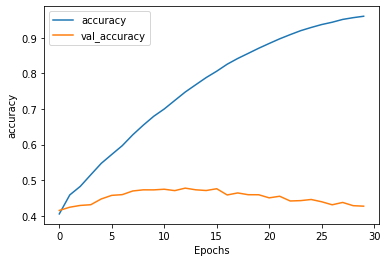

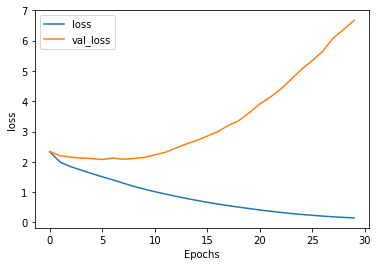

In [13]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

<h2>Visualizing the Embedding</h2>

<h3>1. Getting Weights</h3>

First we need to do get the weights(vectors) from Embedding layer for each of the words

In [14]:
e = model.layers[0]          #Embedding layer
weights = e.get_weights()[0] #getting the weights of each embedded words
print(weights.shape)         # shape: (vocab_size, embedding_dim)

(10000, 16)


<h3>2. Reversing the word index</h3>

To decode the padded list we need to flip the word index. As currently, the word is the 'key' and the token is the 'value' and we need to change it to token being 'key' and word being 'value'

In [15]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(training_padded[1]))
print(training_sentences[1])

will smith joins <OOV> and <OOV> jam for the 2018 world <OOV> official song ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song


<h3>3. Writing Vectors and Metadata</h3>

TensorFlow Projector reads the vector and metadata from a file and plots the vecotrs in a 3D space. 

1. So, we write the co-efficinet of each dimenson of the vector for a word(which is basically each item of the embedding array) in the 'vecs.tsv' file.

2. And we write the words in the 'meta.tsv' file

In [0]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

Below code will download the above created files

In [0]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv') #contains the vector representation of words
  files.download('meta.tsv') #Contains the words

<h3>Instructions to visualize the data</h3>

We can visualize the Embedding in TensorFlow Embedding Projector at this URL: https://projector.tensorflow.org

Here we need to upload the files. This can be done by clicking on the "Load" button. 

For the first one we should upload the 'vecs.tsv' and 'meta.tsv' for the second one.

For a Binary classifier we can go for the "Sphereize data" but as it is not, explore different options.

Lastly...Have fun!!!